# Import Libraries

In [1]:
from tensorflow.keras.utils import normalize
import tensorflow as tf
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
import glob
from tensorflow.keras.callbacks import EarlyStopping
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU
import random
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from keras.models import load_model

# read pathes of data

In [2]:
image_directory = '/kaggle/input/modis-dataset/images'
mask_directory = '/kaggle/input/modis-dataset/annotations'
test_images = '/kaggle/input/test-data-renamed/testImages'
test_masks = '/kaggle/input/test-data-renamed/testMasks'

# read names of images in data

In [3]:
image_names = glob.glob("/kaggle/input/modis-dataset/images/*.jpg")
mask_names = glob.glob("/kaggle/input/modis-dataset/annotations/*.png")
test_images_names = glob.glob("/kaggle/input/test-data-renamed/testImages/*.tif")
test_masks_names = glob.glob("/kaggle/input/test-data-renamed/testMasks/*.tif")

print(image_names[0:6])
print("-----------------------")
print(mask_names[0:6])
print("-----------------------")
print(test_images_names[0:6])
print("-----------------------")
print(test_masks_names[0:6])

['/kaggle/input/modis-dataset/images/45.jpg', '/kaggle/input/modis-dataset/images/56.jpg', '/kaggle/input/modis-dataset/images/20.jpg', '/kaggle/input/modis-dataset/images/58.jpg', '/kaggle/input/modis-dataset/images/6.jpg', '/kaggle/input/modis-dataset/images/76.jpg']
-----------------------
['/kaggle/input/modis-dataset/annotations/41_GT.png', '/kaggle/input/modis-dataset/annotations/49_GT.png', '/kaggle/input/modis-dataset/annotations/21_GT.png', '/kaggle/input/modis-dataset/annotations/76_GT.png', '/kaggle/input/modis-dataset/annotations/15_GT.png', '/kaggle/input/modis-dataset/annotations/36_GT.png']
-----------------------
['/kaggle/input/test-data-renamed/testImages/461_test_image.tif', '/kaggle/input/test-data-renamed/testImages/380_test_image.tif', '/kaggle/input/test-data-renamed/testImages/270_test_image.tif', '/kaggle/input/test-data-renamed/testImages/424_test_image.tif', '/kaggle/input/test-data-renamed/testImages/379_test_image.tif', '/kaggle/input/test-data-renamed/test

# sort names of images in data

In [4]:
image_names = sorted(image_names, key = lambda x: (len (x), x))
mask_names = sorted(mask_names, key = lambda x: (len (x), x))
test_images_names = sorted(test_images_names, key = lambda x: (len (x), x))
test_masks_names = sorted(test_masks_names, key = lambda x: (len (x), x))

print(image_names[0:6])
print("-----------------------")
print(mask_names[0:6])
print("-----------------------")
print(test_images_names[0:6])
print("-----------------------")
print(test_masks_names[0:6])

['/kaggle/input/modis-dataset/images/0.jpg', '/kaggle/input/modis-dataset/images/1.jpg', '/kaggle/input/modis-dataset/images/2.jpg', '/kaggle/input/modis-dataset/images/3.jpg', '/kaggle/input/modis-dataset/images/4.jpg', '/kaggle/input/modis-dataset/images/5.jpg']
-----------------------
['/kaggle/input/modis-dataset/annotations/0_GT.png', '/kaggle/input/modis-dataset/annotations/1_GT.png', '/kaggle/input/modis-dataset/annotations/2_GT.png', '/kaggle/input/modis-dataset/annotations/3_GT.png', '/kaggle/input/modis-dataset/annotations/4_GT.png', '/kaggle/input/modis-dataset/annotations/5_GT.png']
-----------------------
['/kaggle/input/test-data-renamed/testImages/3_test_image.tif', '/kaggle/input/test-data-renamed/testImages/4_test_image.tif', '/kaggle/input/test-data-renamed/testImages/15_test_image.tif', '/kaggle/input/test-data-renamed/testImages/26_test_image.tif', '/kaggle/input/test-data-renamed/testImages/27_test_image.tif', '/kaggle/input/test-data-renamed/testImages/30_test_ima

# Read and resize and normalization for data

In [5]:
images = [cv2.imread(img) for img in image_names]
masks = [cv2.imread(mask,0) for mask in mask_names]
for i in range(len(images)):
    images[i] = cv2.resize(images[i] , (256,256))
    images[i] = cv2.normalize(images[i], None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    masks[i] = cv2.resize(masks[i] , (256,256))
    masks[i] = cv2.normalize(masks[i], None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
test_images = [cv2.imread(img) for img in test_images_names]
for j in range(len(test_images)):
    test_images[j] = cv2.resize(test_images[j] , (256,256))
    test_images[j] = cv2.normalize(test_images[j], None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
test_masks = [cv2.imread(img) for img in test_masks_names]
for j in range(len(test_masks)):
    test_masks[j] = cv2.resize(test_masks[j] , (256,256))
    test_masks[j] = cv2.normalize(test_masks[j], None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# Size of data before Augmentation

In [6]:
print(len(images))
print(len(masks))
print(len(test_images))
print(len(test_masks))

80
80
60
60


# Data Augmentation

In [7]:
augmentation1 = iaa.Sequential([
    iaa.Affine(scale={"x": (0.5, 0.5), "y": (0.5, 0.5)})])

augmentation2 = iaa.Sequential([
    iaa.Affine(scale={"x": (1.5, 1.5), "y": (1.5, 1.5)})])

augmentation3 = iaa.Sequential([
    iaa.Affine(translate_percent={"x": (-0.2, -0.2), "y": (-0.2, -0.2)})])

augmentation4 = iaa.Sequential([
    iaa.Affine(translate_percent={"x": (0.2, 0.2), "y": (0.2, 0.2)})])

augmentation5 = iaa.Sequential([
    iaa.Affine(rotate=(-50, -50))])

augmentation6 = iaa.Sequential([
    iaa.Affine(rotate=(50, 50))])

augmentation7 = iaa.Sequential([
    iaa.Affine(shear=(-50, -50))])


augmentation8 = iaa.Sequential([
    iaa.Affine(shear=(50, 50))])

augmentation9 = iaa.Sequential([
    iaa.Fliplr(1.0)
])
    
augmentation10 = iaa.Sequential([
    iaa.Flipud(1.0)
])

all_aug = augmentation1 + augmentation2 + augmentation3 + augmentation4 + augmentation5 + augmentation6 + augmentation7 + augmentation8 + augmentation9 + augmentation10

all_img=[]
all_img += images
all_masks =[]
all_masks += masks
for i in range(len(all_aug)):
    images_aug = all_aug[i](images=images)
    masks_aug = all_aug[i](images=masks)
    all_img += images_aug
    all_masks += masks_aug

# Size of data after Augmentation

In [8]:
print(len(all_img))
print(len(all_masks))

880
880


# visualize image and its mask
img[0] is img[80]aply Augmentation1 is img[160]aply Augmentation2 is img[240]aply Augmentation3 is etc...

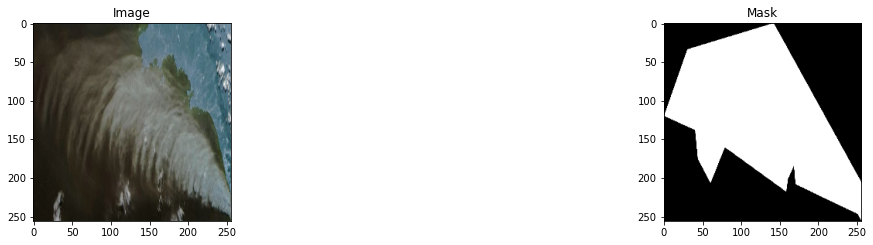

In [9]:
i=0
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(all_img[i], cmap='gray')
plt.subplot(233)
plt.title('Mask')
plt.imshow(all_masks[i], cmap='gray')

plt.show()

# convert data to numpy array

In [10]:
image_dataset = np.array(all_img) 
mask_dataset = np.array(all_masks)
test_images_dataset = np.array(test_images)
test_masks_dataset = np.array(test_masks)

In [11]:
mask_dataset.resize(len(all_masks),256,256,1) 
test_masks_dataset.resize(len(test_masks),256,256,1)

# print data shapes

In [12]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Test Images data shape is: ", test_images_dataset.shape)
print("Test Masks data shape is: ", test_masks_dataset.shape)

Image data shape is:  (880, 256, 256, 3)
Mask data shape is:  (880, 256, 256, 1)
Test Images data shape is:  (60, 256, 256, 3)
Test Masks data shape is:  (60, 256, 256, 1)


# split data for train and test

In [13]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(image_dataset, mask_dataset, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.111, random_state=42)

# print data shapes after split

In [14]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(704, 256, 256, 3)
(704, 256, 256, 1)
(88, 256, 256, 3)
(88, 256, 256, 1)
(88, 256, 256, 3)
(88, 256, 256, 1)


# Build our U-net model

In [15]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network. 
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling


def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p   

#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024) #Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:  #Binary
      activation = 'sigmoid'
    else:
      activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
    print(activation)

    model = Model(inputs, outputs, name="U-Net")
    return model

# read data shapes

In [16]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH  = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]

input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
input_shape

(256, 256, 3)

# Call model and print his summary

In [17]:
model = build_unet(input_shape, n_classes=1)
model.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________

# train model

In [18]:
history = model.fit(X_train, y_train, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=100, 
                    validation_data=(X_val, y_val), 
                    shuffle=True)

Epoch 1/100
22/22 [==============================] - 34s 931ms/step - loss: 0.4098 - accuracy: 0.8098 - val_loss: 1.1724 - val_accuracy: 0.6126
Epoch 2/100
22/22 [==============================] - 18s 813ms/step - loss: 0.3262 - accuracy: 0.8457 - val_loss: 3.2490 - val_accuracy: 0.3721
Epoch 3/100
22/22 [==============================] - 18s 810ms/step - loss: 0.3269 - accuracy: 0.8458 - val_loss: 1.7310 - val_accuracy: 0.3441
Epoch 4/100
22/22 [==============================] - 18s 812ms/step - loss: 0.3211 - accuracy: 0.8484 - val_loss: 4.4373 - val_accuracy: 0.3721
Epoch 5/100
22/22 [==============================] - 18s 810ms/step - loss: 0.3165 - accuracy: 0.8509 - val_loss: 10.6624 - val_accuracy: 0.3721
Epoch 6/100
22/22 [==============================] - 18s 810ms/step - loss: 0.3133 - accuracy: 0.8540 - val_loss: 2.1415 - val_accuracy: 0.3968
Epoch 7/100
22/22 [==============================] - 18s 810ms/step - loss: 0.3056 - accuracy: 0.8559 - val_loss: 2.1635 - val_accuracy

# Evaluation of dependent dataset

In [20]:
loss, accuracy = model.evaluate(X_test, y_test)

# Print the test loss and accuracy
print('Test loss:', loss)
print('Test accuracy:', accuracy)

3/3 [==============================] - 1s 228ms/step - loss: 0.2461 - accuracy: 0.9047
Test loss: 0.246087446808815
Test accuracy: 0.9046958684921265


# Save the model for future use

In [21]:
# model.save('U-Net model 91-84.hdf5')

# Load previously saved model

In [22]:
# model = load_model("/kaggle/input/save-model-unet/U-Net model 91-84.hdf5", compile=True)

# Visualize loss plot and accurcy plot for both training and validation

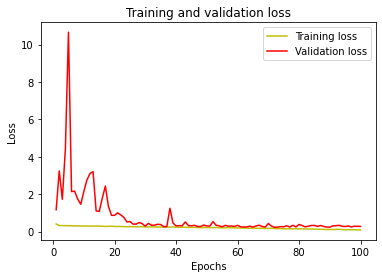

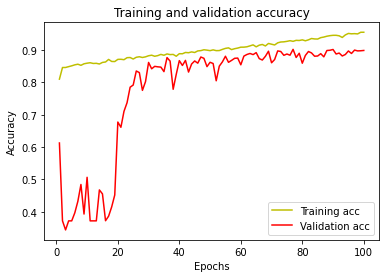

In [23]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Predict our model

In [24]:
y_pred=model.predict(X_test)
y_pred_thresholded = y_pred > 0.5

# Model evaluation by Intersection Over Union(IOU)

In [25]:
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_pred_thresholded, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.82752514


# Visaulize our prediction

(1, 256, 256, 3)
(256, 256)


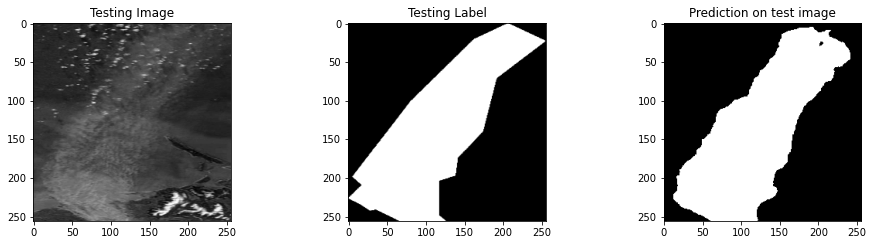

In [42]:
threshold = 0.5
test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_input.shape)
prediction = (y_pred[test_img_number][:,:,0] > threshold).astype(np.uint8)
print(prediction.shape)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()